In [1]:
!pip install -q datasets transformers scikit-learn shap umap-learn matplotlib optuna ray[tune] plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import pandas as pd
from math import sqrt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from torch.utils.data import DataLoader

import optuna  

In [3]:
SEED = 42
MODEL_NAME = "distilbert-base-uncased"
SPLIT_TRAIN_RATIO = 0.7
SPLIT_VAL_RATIO = 0.15  # leftover => test
CALIBRATION_BINS = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
dataset = load_dataset("oishooo/formality_classification")
full_data = dataset["train"]  # single "train" split

data_list = []
for item in full_data:
    txt = str(item["text"]) if item["text"] else ""
    lbl = item["formality_label"]  # "formal","informal","neutral"
    data_list.append({"text": txt, "label_str": lbl})

random.shuffle(data_list)
n_total = len(data_list)
print(f"Total samples: {n_total}")

README.md:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


formality_dataset.csv:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2523 [00:00<?, ? examples/s]

Total samples: 2523


In [5]:
train_size = int(SPLIT_TRAIN_RATIO * n_total)
val_size   = int(SPLIT_VAL_RATIO * n_total)
test_size  = n_total - train_size - val_size

train_data_list = data_list[:train_size]
val_data_list   = data_list[train_size : train_size + val_size]
test_data_list  = data_list[train_size + val_size : ]

print(f"Train: {len(train_data_list)}, Val: {len(val_data_list)}, Test: {len(test_data_list)}")


Train: 1766, Val: 378, Test: 379


In [6]:

label2id = {"formal": 0, "informal": 1, "neutral": 2}
id2label = {0: "formal", 1: "informal", 2: "neutral"}

def encode_label(lbl_str):
    return label2id[lbl_str]

In [7]:
def plot_class_distribution_interactive(train_data, val_data, test_data):
    # Count each label in train, val, test
    unique_labels = ["formal","informal","neutral"]

    def label_counts(data_list):
        return [sum(1 for x in data_list if x["label_str"]==lbl) for lbl in unique_labels]

    train_counts = label_counts(train_data)
    val_counts   = label_counts(val_data)
    test_counts  = label_counts(test_data)

    # We'll create a DataFrame for Plotly
    df_dist = pd.DataFrame({
        "Label": unique_labels*3,
        "Count": train_counts + val_counts + test_counts,
        "Set"  : ["Train"]*3 + ["Val"]*3 + ["Test"]*3
    })

    fig = px.bar(
        df_dist,
        x="Label",
        y="Count",
        color="Set",
        barmode="group",
        title="Interactive Class Distribution"
    )
    fig.show()

plot_class_distribution_interactive(train_data_list, val_data_list, test_data_list)


In [8]:
def build_dataset(dlist, tokenizer):
    ds = Dataset.from_list(dlist)
    def tokenize_map(ex):
        enc = tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128)
        enc["label"] = encode_label(ex["label_str"])
        return enc
    ds = ds.map(tokenize_map, batched=False)
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    return ds

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = build_dataset(train_data_list, tokenizer)
val_dataset   = build_dataset(val_data_list, tokenizer)
test_dataset  = build_dataset(test_data_list, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1766 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

In [10]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./formality-clf-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2,3,4]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
        "weight_decay": trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True),
    }

print("\n=== Starting hyperparameter search with optuna... ===")
search_result = trainer.hyperparameter_search(
    backend="optuna",
    direction="minimize",
    hp_space=hp_space_optuna,
    n_trials=8,
    compute_objective=lambda metrics: metrics["eval_loss"]
)
print("Best hyperparams found (optuna):", search_result.hyperparameters)

best_hp = search_result.hyperparameters


[I 2025-04-06 15:18:00,680] A new study created in memory with name: no-name-d487872d-79eb-4fbe-9482-c16ce6ad6fd7
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Starting hyperparameter search with optuna... ===


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.378200,0.391076,0.857143,0.855429,0.857143,0.848760
2,0.271400,0.447579,0.865079,0.881969,0.865079,0.868712
3,0.009600,0.446520,0.891534,0.891859,0.891534,0.891688
4,0.006500,0.448431,0.888889,0.888901,0.888889,0.888859


[I 2025-04-06 15:19:11,535] Trial 0 finished with value: 0.4484308660030365 and parameters: {'learning_rate': 4.1285046653284875e-05, 'num_train_epochs': 4, 'warmup_ratio': 0.10787367136301536, 'weight_decay': 0.008706003257442935}. Best is trial 0 with value: 0.4484308660030365.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305300,0.338051,0.870370,0.867441,0.870370,0.867934
2,0.211400,0.348730,0.870370,0.867498,0.870370,0.868027


[I 2025-04-06 15:19:48,429] Trial 1 finished with value: 0.3487299084663391 and parameters: {'learning_rate': 1.9992149730270565e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.06009930069355962, 'weight_decay': 0.01057028140296436}. Best is trial 1 with value: 0.3487299084663391.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.395400,0.418511,0.857143,0.856375,0.857143,0.848013
2,0.228800,0.410957,0.880952,0.884382,0.880952,0.882194
3,0.024500,0.395454,0.891534,0.890540,0.891534,0.890906


[I 2025-04-06 15:20:41,805] Trial 2 finished with value: 0.39545440673828125 and parameters: {'learning_rate': 4.5316675527595767e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.18220442882921717, 'weight_decay': 0.0369395258717733}. Best is trial 1 with value: 0.3487299084663391.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.312600,0.341814,0.870370,0.867490,0.870370,0.868000
2,0.207300,0.358387,0.873016,0.870663,0.873016,0.871323


[I 2025-04-06 15:21:18,305] Trial 3 finished with value: 0.35838717222213745 and parameters: {'learning_rate': 2.2517868479185287e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.04209102540553394, 'weight_decay': 0.06013967330230756}. Best is trial 1 with value: 0.3487299084663391.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.326400,0.366373,0.873016,0.870130,0.873016,0.869919
2,0.253500,0.337544,0.873016,0.870346,0.873016,0.870842


[I 2025-04-06 15:21:54,889] Trial 4 finished with value: 0.3375435471534729 and parameters: {'learning_rate': 1.307659473795493e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.16043578656710142, 'weight_decay': 0.006774721446254309}. Best is trial 4 with value: 0.3375435471534729.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319800,0.353481,0.875661,0.873534,0.875661,0.873305
2,0.271200,0.443942,0.870370,0.880460,0.870370,0.872870
3,0.006400,0.470488,0.891534,0.890442,0.891534,0.890522
4,0.045300,0.488875,0.873016,0.872337,0.873016,0.872610


[I 2025-04-06 15:23:05,425] Trial 5 finished with value: 0.48887500166893005 and parameters: {'learning_rate': 2.4847766823623538e-05, 'num_train_epochs': 4, 'warmup_ratio': 0.035424121208676995, 'weight_decay': 0.007838473322968633}. Best is trial 4 with value: 0.3375435471534729.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.327700,0.365264,0.865079,0.861590,0.865079,0.861509


[I 2025-04-06 15:23:21,476] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.309200,0.343131,0.870370,0.867526,0.870370,0.867922
2,0.218800,0.348877,0.870370,0.867788,0.870370,0.868416


[I 2025-04-06 15:23:58,685] Trial 7 finished with value: 0.34887680411338806 and parameters: {'learning_rate': 1.9473927757405922e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.13227874015926228, 'weight_decay': 0.04888126651160941}. Best is trial 4 with value: 0.3375435471534729.


Best hyperparams found (optuna): {'learning_rate': 1.307659473795493e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.16043578656710142, 'weight_decay': 0.006774721446254309}


In [13]:
best_training_args = TrainingArguments(
    output_dir="./formality-clf-output-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    num_train_epochs=int(best_hp["num_train_epochs"]),
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=best_hp["learning_rate"],
    warmup_ratio=best_hp["warmup_ratio"],
    weight_decay=best_hp["weight_decay"],
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

best_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("\n=== Training final model with best hyperparams... ===")
best_trainer.train()

test_results = best_trainer.evaluate(test_dataset)
print("\nFinal test set results with best hyperparams:", test_results)

logits = best_trainer.predict(test_dataset).predictions
labels_true = best_trainer.predict(test_dataset).label_ids
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
pred_classes = np.argmax(probs, axis=1)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training final model with best hyperparams... ===


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.326400,0.366373,0.873016,0.870130,0.873016,0.869919
2,0.253500,0.337544,0.873016,0.870346,0.873016,0.870842



Final test set results with best hyperparams: {'eval_loss': 0.29294201731681824, 'eval_accuracy': 0.8891820580474934, 'eval_precision': 0.8887385626632786, 'eval_recall': 0.8891820580474934, 'eval_f1': 0.8884942130248787, 'eval_runtime': 0.8951, 'eval_samples_per_second': 423.424, 'eval_steps_per_second': 53.626, 'epoch': 2.0}


In [14]:
cm = confusion_matrix(labels_true, pred_classes)
print("\nPlain Confusion Matrix:\n", cm)

labels_ordered = ["formal","informal","neutral"]
df_cm = pd.DataFrame(cm, index=labels_ordered, columns=labels_ordered)

fig_cm = px.imshow(
    df_cm,
    text_auto=True,
    aspect="auto",
    title="Interactive Confusion Matrix",
    labels=dict(x="Predicted", y="True", color="Count")
)
fig_cm.update_xaxes(side="bottom")
fig_cm.show()



Plain Confusion Matrix:
 [[131   0   4]
 [  0 117  16]
 [ 12  10  89]]


In [15]:
def train_and_eval_kfold(data_list, k=3):
    all_labels = [encode_label(x["label_str"]) for x in data_list]
    indices = np.arange(len(data_list))
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    fold_accuracies, fold_f1s = [], []

    for fold_idx, (tr_idx, vl_idx) in enumerate(skf.split(indices, all_labels)):
        print(f"\n=== K-Fold Fold {fold_idx+1}/{k} ===")

        tr_list = [data_list[i] for i in tr_idx]
        vl_list = [data_list[i] for i in vl_idx]

        ds_tr = build_dataset(tr_list, tokenizer)
        ds_vl = build_dataset(vl_list, tokenizer)

        # We'll re-use the best HP but disable saving for cross-validation
        fold_args = TrainingArguments(
            output_dir=f"./fold_{fold_idx+1}_output",
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="steps",
            logging_steps=10,
            num_train_epochs=int(best_hp["num_train_epochs"]),
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            learning_rate=best_hp["learning_rate"],
            warmup_ratio=best_hp["warmup_ratio"],
            weight_decay=best_hp["weight_decay"],
            fp16=torch.cuda.is_available(),
            load_best_model_at_end=False,  # Must be false if no saving
            metric_for_best_model="eval_loss",
            report_to="none"
        )

        fold_trainer = Trainer(
            model_init=model_init,
            args=fold_args,
            train_dataset=ds_tr,
            eval_dataset=ds_vl,
            compute_metrics=compute_metrics
        )

        fold_trainer.train()
        results = fold_trainer.evaluate(ds_vl)
        fold_accuracies.append(results["eval_accuracy"])
        fold_f1s.append(results["eval_f1"])
        print(f"Fold {fold_idx+1} => Accuracy: {results['eval_accuracy']:.4f}, F1: {results['eval_f1']:.4f}")

    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy: mean={np.mean(fold_accuracies):.4f}, std={np.std(fold_accuracies):.4f}")
    print(f"F1      : mean={np.mean(fold_f1s):.4f}, std={np.std(fold_f1s):.4f}")

print("\n=== OPTIONAL: K-Fold Cross Validation with best hyperparams ===")
train_and_eval_kfold(data_list, k=3)


=== OPTIONAL: K-Fold Cross Validation with best hyperparams ===

=== K-Fold Fold 1/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.295500,0.335166,0.879905,0.877219,0.879905,0.876900
2,0.259800,0.290155,0.890606,0.889135,0.890606,0.889357


Fold 1 => Accuracy: 0.8906, F1: 0.8894

=== K-Fold Fold 2/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.491900,0.341411,0.865636,0.867223,0.865636,0.855375
2,0.267900,0.283164,0.885850,0.883570,0.885850,0.884154


Fold 2 => Accuracy: 0.8859, F1: 0.8842

=== K-Fold Fold 3/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.476600,0.343063,0.884661,0.886603,0.884661,0.885435
2,0.163900,0.300446,0.888228,0.888831,0.888228,0.888130


Fold 3 => Accuracy: 0.8882, F1: 0.8881

=== Cross-Validation Summary ===
Accuracy: mean=0.8882, std=0.0019
F1      : mean=0.8872, std=0.0022


In [16]:
pred_confidences = np.max(probs, axis=1)
frac_of_pos, mean_pred_val = calibration_curve(
    (pred_classes == labels_true).astype(int),
    pred_confidences,
    n_bins=CALIBRATION_BINS
)

df_calib = pd.DataFrame({
    "mean_pred": mean_pred_val,
    "frac_pos" : frac_of_pos
})

fig_calib = px.line(
    df_calib,
    x="mean_pred",
    y="frac_pos",
    markers=True,
    title="Interactive Reliability Diagram"
)
fig_calib.add_shape(
    type="line",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="gray", dash="dash")
)
fig_calib.update_layout(
    xaxis_title="Predicted Probability",
    yaxis_title="True Probability"
)
fig_calib.show()

In [17]:
acc = accuracy_score(labels_true, pred_classes)
n_test = len(labels_true)
z = 1.96
center = (acc + (z**2)/(2*n_test)) / (1 + (z**2)/n_test)
margin = (z * np.sqrt((acc*(1-acc) + (z**2)/(4*n_test)) / n_test)) / (1 + (z**2)/n_test)
ci_lower = center - margin
ci_upper = center + margin
print(f"\nAccuracy: {acc:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")



Accuracy: 0.8892 (95% CI: [0.8536, 0.9170])


In [18]:
mis_idx = np.where(pred_classes != labels_true)[0]
print(f"\nNumber of misclassifications: {len(mis_idx)}")
random.shuffle(mis_idx)
for i in mis_idx[:5]:
    txt = test_data_list[i]["text"]
    print("\n--- Misclassification ---")
    print("Text:", txt)
    print("True Label:", id2label[labels_true[i]])
    print("Pred Label:", id2label[pred_classes[i]])


Number of misclassifications: 42

--- Misclassification ---
Text: For example, two sponsors said they had to make changes to terms and conditions for loans late in the process.
True Label: neutral
Pred Label: formal

--- Misclassification ---
Text: hello friend I am very happy we can discuss about business experience.
True Label: neutral
Pred Label: informal

--- Misclassification ---
Text: Making a definitive judgment on an entire group of individuals based on their sex is the definition of sexism. Regardless of what sex YOU are.  And your suggestion of mandating compulsory service is the most dictator thing I ever heard.
True Label: informal
Pred Label: neutral

--- Misclassification ---
Text: The international routing service in India?
True Label: informal
Pred Label: neutral

--- Misclassification ---
Text: Legislation .
True Label: formal
Pred Label: neutral


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



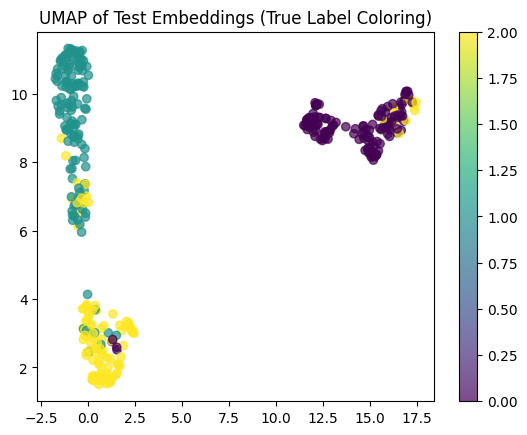

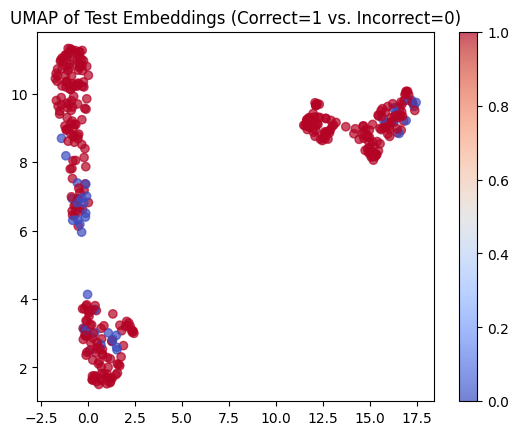

In [19]:
def get_embeddings(m, ds):
    loader = DataLoader(ds, batch_size=8, shuffle=False)
    m.eval()
    emb_list = []
    with torch.no_grad():
        for batch in loader:
            in_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            out = m.distilbert(in_ids, attention_mask=attn)
            cls_emb = out.last_hidden_state[:, 0, :]
            emb_list.append(cls_emb.cpu().numpy())
    return np.concatenate(emb_list, axis=0)

test_embs = get_embeddings(best_trainer.model, test_dataset)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED)
umap_2d = umap_reducer.fit_transform(test_embs)

plt.figure()
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels_true, cmap='viridis', alpha=0.7)
plt.title("UMAP of Test Embeddings (True Label Coloring)")
plt.colorbar()
plt.show()

corr_mask = (pred_classes==labels_true).astype(int)
plt.figure()
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=corr_mask, cmap='coolwarm', alpha=0.7)
plt.title("UMAP of Test Embeddings (Correct=1 vs. Incorrect=0)")
plt.colorbar()
plt.show()

In [20]:
print("\n=== SHAP with KernelExplainer (one text = one feature) ===")

def model_predict_for_shap(text_2d_array):
    texts = [str(row[0]) for row in text_2d_array]
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    with torch.no_grad():
        out = best_trainer.model(**inputs).logits
        probs_ = torch.softmax(out, dim=-1).cpu().numpy()
    return probs_

bg_samples = random.sample(train_data_list, 3)
bg_texts = np.array([x["text"] for x in bg_samples], dtype=object).reshape(-1,1)
explainer = shap.KernelExplainer(
    model_predict_for_shap,
    bg_texts,
    link="identity"
)

test_samples = random.sample(test_data_list, 3)
test_text_array = np.array([ts["text"] for ts in test_samples], dtype=object).reshape(-1,1)
shap_vals = explainer.shap_values(test_text_array, nsamples=50)

for i,ts in enumerate(test_samples):
    print(f"\nExample {i} => text: {repr(ts['text'])}")
    for cls_idx in range(3):
        shap_val = shap_vals[cls_idx][i][0]
        print(f"   Class {cls_idx} shap: {shap_val:.4f}")

print("\nNote: Single text is 1 'feature' => only 1 shap value per class.\n")

print("\nAll done! Full pipeline with interactive Plotly visualizations that JetBrains folks or any dev team might enjoy.\n")



=== SHAP with KernelExplainer (one text = one feature) ===


  0%|          | 0/3 [00:00<?, ?it/s]


Example 0 => text: 'There was no F-UP at all!  That story is straight up awesome. '
   Class 0 shap: -0.3389
   Class 1 shap: 0.6312
   Class 2 shap: -0.2923

Example 1 => text: "That's not Ty, it's Robert."
   Class 0 shap: -0.3382
   Class 1 shap: 0.6108
   Class 2 shap: -0.2726

Example 2 => text: "Have you ever watched face 2 face on Netflix? My friend watched it and wanted me to watch it as well. It seems pretty much like a lame romance movie, so to make it more exciting, because I was bored out of my mind, I started making jokes that (as far as I knew) placed way too much emphasis on seemingly insignificant lines. I ended up guessing the entire movie. As a joke. I think there were four or five plot twists and I got every single one right. My friend couldn't believe that I hadn't watched the movie."
   Class 0 shap: -0.3396
   Class 1 shap: 0.6265
   Class 2 shap: -0.2869

Note: Single text is 1 'feature' => only 1 shap value per class.


All done! Full pipeline with interactive 